In [93]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .05
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [7]:
model = load_model("madry_model.h5")

2022-04-18 15:19:24.605484: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 15:19:24.608685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-18 15:19:24.608908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-18 15:19:24.609107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-18 15:19:24.609154: I tensorflow/stream_executor/

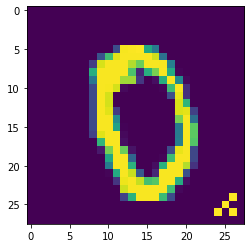

Prediction: 0

 Effectiveness of poison: 1.33%


In [10]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(model.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0] 

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [11]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(model.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

492
526
93.5361216730038  % accuracy


In [12]:
clean_x_test = x_test[is_poison_test==0]
clean_y_test = y_test[is_poison_test==0]

clean_preds = np.argmax(model.predict(clean_x_test), axis=1)
ct=0
for i in range(len(clean_preds)):
  jhc=(clean_preds[i])%10
  if clean_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(clean_preds))
print(100*ct/len(clean_preds)," % accuracy")

9274
10000
92.74  % accuracy


In [115]:
class_now = 8
poison_y_test_unohv = np.argmax(poison_y_test, axis = 1)
poison_x_test_three = poison_x_test[poison_y_test_unohv == (class_now + 1)%10]
n_pois_three = poison_preds_three.shape[0]

clean_y_test_unohv = np.argmax(clean_y_test, axis = 1)
clean_x_test_three = clean_x_test[clean_y_test_unohv == class_now][:n_pois_three]

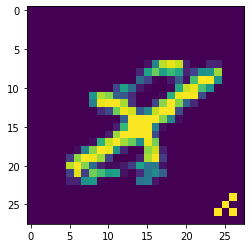

In [116]:
plt.imshow(poison_x_test_three[0, :, :, :].squeeze())

In [117]:
last_out =  model.get_layer("dense").output
last_layer_model = Model(inputs = model.input, outputs = last_out)

In [118]:
poison_preds_three = last_layer_model.predict(poison_x_test_three)
clean_preds_three = last_layer_model.predict(clean_x_test_three)

In [119]:
preds_three = np.vstack((poison_preds_three, clean_preds_three))

In [120]:
from sklearn.manifold import TSNE

In [121]:
tsne = TSNE(n_components=2, verbose=1, random_state=13)
preds_vis = tsne.fit_transform(preds_three)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 2.388759
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.640133
[t-SNE] KL divergence after 1000 iterations: 0.387659


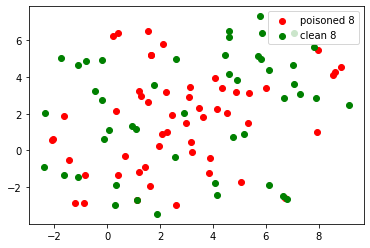

In [122]:
n_pois_three = poison_preds_three.shape[0]
plt.scatter(preds_vis[:n_pois_three, 0], preds_vis[:n_pois_three, 1], color="red", label="poisoned 8")
plt.scatter(preds_vis[n_pois_three:, 0], preds_vis[n_pois_three:, 1], color="green", label = "clean 8")
plt.legend()
plt.show()

In [105]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')


# ax.scatter(preds_vis[:n_pois_three, 0], preds_vis[:n_pois_three, 1], preds_vis[:n_pois_three, 2],  color="red", label="poisoned 3")
# ax.scatter(preds_vis[n_pois_three:, 0], preds_vis[n_pois_three:, 1], preds_vis[n_pois_three:, 2],  color="green", label="clean 3")

# plt.legend()
# plt.show()